In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import cv2
import matplotlib.pylab as plt
import pandas as pd
%matplotlib inline

Mounted at /content/drive


## Libraries

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Load image's path and mask's path

In [ ]:
import glob
images_path = glob.glob('/content/drive/MyDrive/AllMassFile/*.png')
mask_path = glob.glob('/content/drive/MyDrive/mask&images/*.png')

image_normal = glob.glob('/content/drive/MyDrive/in-breast/normal/*.png')
mask_normal = glob.glob('/content/drive/MyDrive/normalmask/*.png')

In [ ]:
MASS_PATIENT_ID = ['53586896', '22580192', '22614236', '22580098', '24055445', '30011674', 
                   '20586934', '22670465', '24055502', '22670673', '20587612', '22614568', 
                   '20587902', '22614522', '50995789', '24055464', '20588216', '51049053', 
                   '53582656', '20588562', '27829188', '22614431', '22580341', '22613822', 
                   '24065584', '50997515', '51049107', '22580367', '22580244', '50996352', 
                   '22670147', '22580732', '50999008', '24065707', '22614127', '20588334', 
                   '20588536', '24065530', '22670324', '20586908', '30011507', '27829134', 
                   '53581406', '50998981', '20586986', '22678787', '50997461', '53580804', 
                   '22579730', '22670094', '53580858', '53586869', '50995762', '24065251', 
                   '20587810', '53581460', '22670855', '22580706', '30011553', '22670809', 
                   '22580419', '24055355', '53587014', '50994408', '22614379', '22670278', 
                   '24065289', '22614074', '24055274', '22670511', '50994354', '20587928', 
                   '22580393', '22580654', '20588046', '50994273', '20587758', '24065761', 
                   '22427751', '20587664', '50999432', '22580680', '22580038', '53587663', 
                   '20588308', '20588680', '30011727', '22678833', '22427705', '22614266', 
                   '22613650', '50999459', '24055483', '22678694', '20587994', '22678646', 
                   '53582683', '20586960', '51048765', '22670620', '22613770', '22427840', 
                   '20588190', '53586960', '50996406', '22613702', '51048738']

In [ ]:
import os
file_names_mask =[]
for filename in os.listdir('/content/drive/MyDrive/mask&images'):
    if filename.endswith(".png"):
          if filename[:8] in MASS_PATIENT_ID:
              file_names_mask.append('/content/drive/MyDrive/mask&images/'+filename)

In [ ]:
len(file_names_mask)

107

In [ ]:
file_names_mask.sort()

In [ ]:
file_names_mass =[]
for filename in os.listdir('/content/drive/MyDrive/AllMassFile'):
    if filename.endswith(".png"):
          if filename[:8] in MASS_PATIENT_ID:
              file_names_mass.append('/content/drive/MyDrive/AllMassFile/'+filename)

In [ ]:
len(file_names_mass)

107

In [ ]:
file_names_mass.sort()

In [ ]:
len(image_normal),len(mask_normal)

(107, 107)

In [ ]:
image_normal.sort(),mask_normal.sort()

(None, None)

## Data Visualization

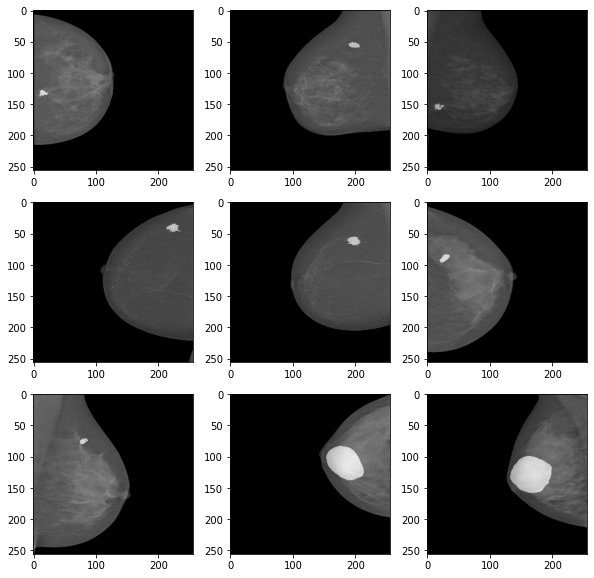

In [ ]:
#Lets plot some abnormal samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=file_names_mass[i]
    msk_path=file_names_mask[i]
    img=cv2.imread(img_path)
    img=cv2.resize(img,(256,256))
    # img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    msk=cv2.resize(msk,(256,256))
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

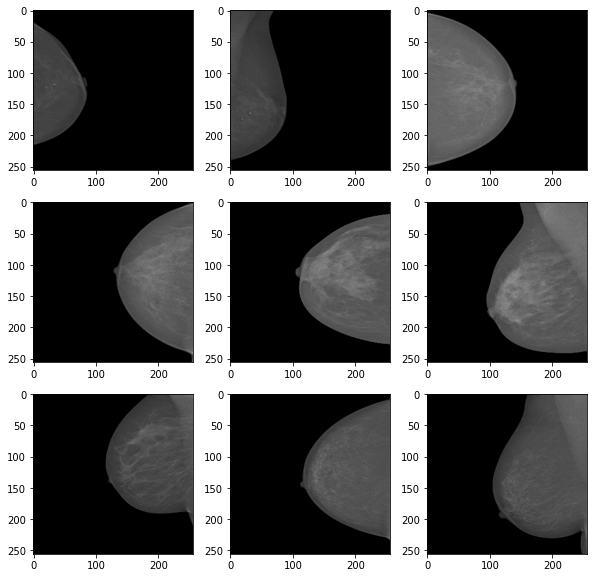

In [ ]:
#Lets plot some normal samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=image_normal[i]
    msk_path=mask_normal[i]
    img=cv2.imread(img_path)
    img=cv2.resize(img,(256,256))
    # img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    msk=cv2.resize(msk,(256,256))
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

## Create data frame and split data on train set, validation set and test set

In [ ]:
files = [*file_names_mass, *image_normal] 
mask = [*file_names_mask, *mask_normal] 

In [ ]:
df = pd.DataFrame(data={"filename": files, 'mask' : mask})
shuffled = df.sample(frac=1)

df_train, df_test = train_test_split(shuffled,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(153, 2)
(39, 2)
(22, 2)


In [ ]:
shuffled

## Data genertator, data augmentation and adjust data

The steps_per_epoch parameter is key because an ImageDataGenerator can provide an infinite number of versions of each image. In this example, the batch_size parameter passed to flow tells the generator to create 10 images in each batch (each call to next). Dividing the number of images by the image batch size to calculate steps_per_epoch ensures that in each training epoch, the model is provided with one transformed version of each image in the dataset.

In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(224,224),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

## Define loss function and metrics

In [ ]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

## Define Unet

In [ ]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

## Training

In [ ]:
# !pip3 install keras==2.3.1
!pip3 install -U segmentation-models

In [ ]:
#Define the model
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
EPOCHS = 300
BATCH_SIZE = 32
learning_rate = 1e-4

In [ ]:
from segmentation_models import metrics
# define model
model = sm.Unet()
# model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=[sm.losses.bce_dice_loss, sm.losses.bce_jaccard_loss], 
                     metrics=[sm.metrics.precision, sm.metrics.recall, sm.metrics.f1_score, sm.metrics.iou_score])
print(model.summary())

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 on)                            256)                                                              
                                                                                                  
 decoder_stage0b_conv (Conv2D)  (None, None, None,   589824      ['decoder_stage0a_relu[0][0]']   
                                256)                                                              
                                                                                                  
 decoder_stage0b_bn (BatchNorma  (None, None, None,   1024       ['decoder_stage0b_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 decoder_stage0b_relu (Activati  (None, None, None,   0          ['decoder_stage0b_bn[0][0]']     
 on)                            256)                                                              
          

In [ ]:
im_height = 224
im_width = 224

Found 153 validated image filenames.
Found 153 validated image filenames.
Epoch 1/300
10/10 [==============================] - ETA: 0s - loss: 1.8474 - precision: 0.0046 - recall: 0.5814 - f1-score: 0.0090 - iou_score: 0.0045 Found 39 validated image filenames.
Found 39 validated image filenames.

Epoch 1: val_loss improved from inf to 1.42209, saving model to /content/drive/MyDrive/ModelCheckpoint/resenet_unet_segmentationusingNeewMetrics__.hdf5
10/10 [==============================] - 203s 20s/step - loss: 1.8474 - precision: 0.0046 - recall: 0.5814 - f1-score: 0.0090 - iou_score: 0.0045 - val_loss: 1.4221 - val_precision: 0.0036 - val_recall: 0.1912 - val_f1-score: 0.0070 - val_iou_score: 0.0035
Epoch 2/300
10/10 [==============================] - ETA: 0s - loss: 1.6947 - precision: 0.0044 - recall: 0.5076 - f1-score: 0.0086 - iou_score: 0.0043
Epoch 2: val_loss did not improve from 1.42209
10/10 [==============================] - 81s 9s/step - loss: 1.6947 - precision: 0.0044 - rec

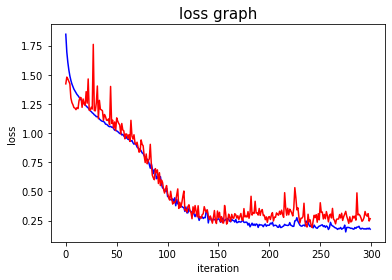

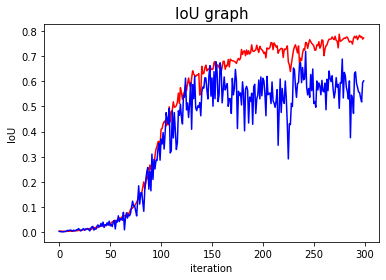

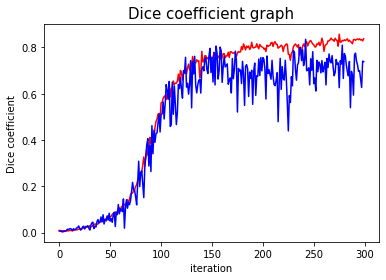

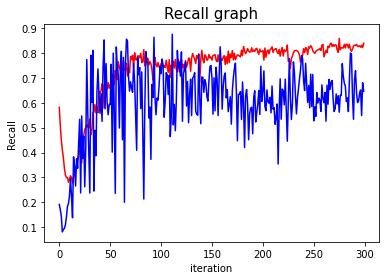

In [ ]:
train_generator_args = dict(rotation_range=0.5,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.05,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
callbacks = [ModelCheckpoint('/content/drive/MyDrive/ModelCheckpoint/resenet_unet_segmentationusingNeewMetrics__.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=10, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=10)

## plotting curves

a = history.history

plt.figure(1)
plt.plot(a['loss'], 'b-')
plt.plot(a['val_loss'],'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)


plt.figure(2)
plt.plot(a['iou_score'], 'r-')
plt.plot(a['val_iou_score'], 'b-')
plt.xlabel('iteration')
plt.ylabel('IoU')
plt.title('IoU graph', fontsize = 15)


plt.figure(3)
plt.plot(a['f1-score'], 'r-')
plt.plot(a['val_f1-score'], 'b-')
plt.xlabel('iteration')
plt.ylabel('Dice coefficient')
plt.title('Dice coefficient graph', fontsize = 15)

plt.figure(4)
plt.plot(a['recall'], 'r-')
plt.plot(a['val_recall'], 'b-')
plt.xlabel('iteration')
plt.ylabel('Recall')
plt.title('Recall graph', fontsize = 15)

plt.show()

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=10)

Found 22 validated image filenames.
Found 22 validated image filenames.
10/10 [==============================] - 31s 3s/step - loss: 0.1608 - precision: 0.9707 - recall: 0.7607 - f1-score: 0.8530 - iou_score: 0.7436


In [ ]:
print("Test lost:   ",results[0])
print("precision:   ",results[1])
print("Recall   :   ",results[2])
print("f1-score :   ",results[3])
print("iou_score:   ",results[4])

Test lost:    0.1608489602804184
precision:    0.9707251787185669
Recall   :    0.7606843709945679
f1-score :    0.8529645204544067
iou_score:    0.7436252236366272


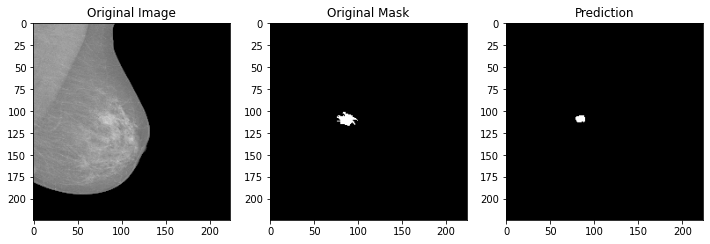

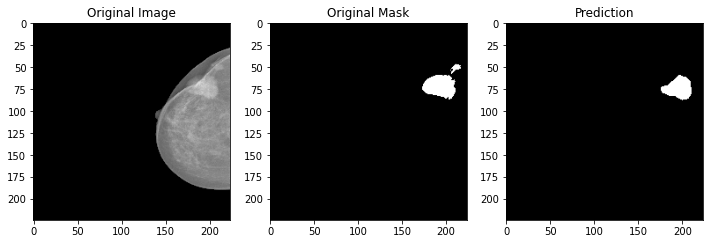

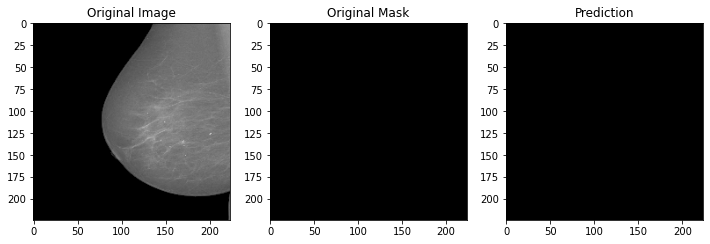

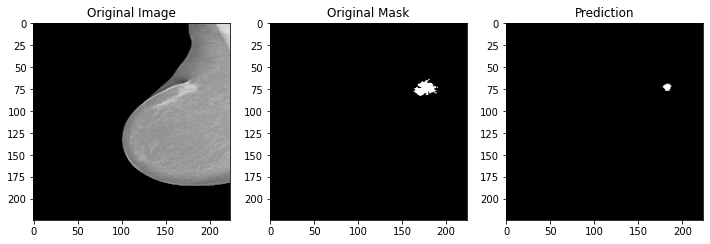

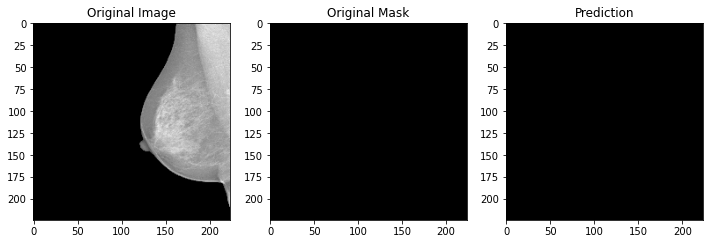

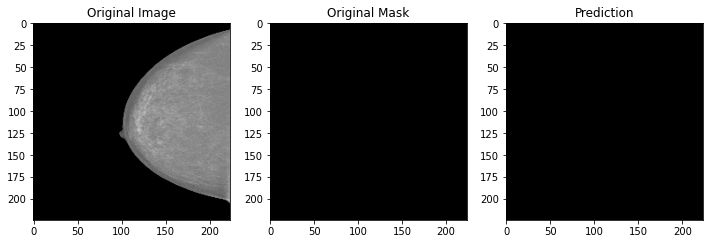

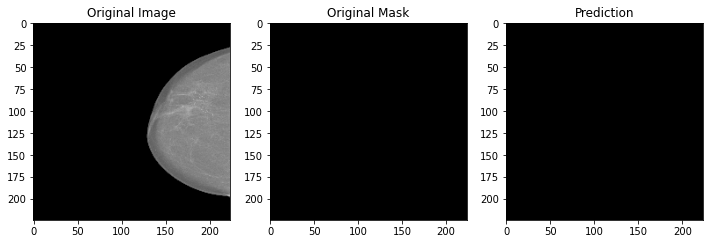

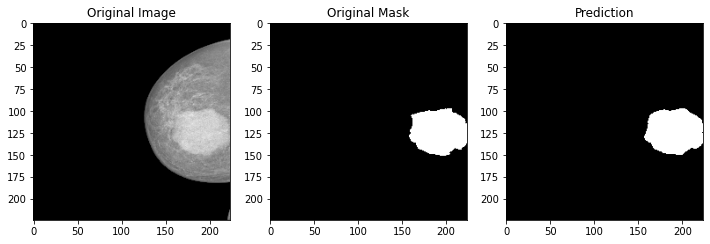

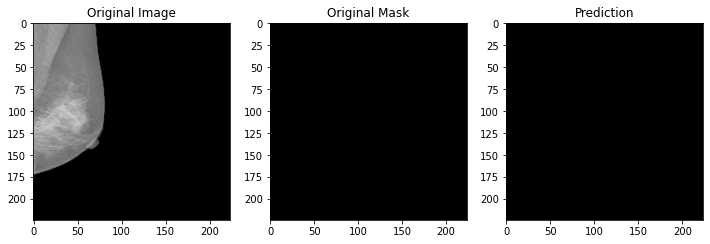

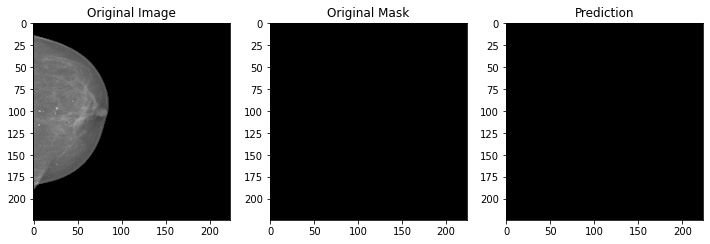

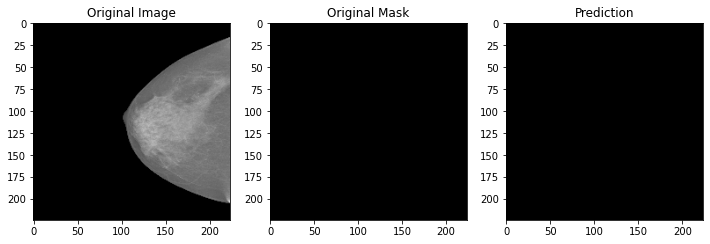

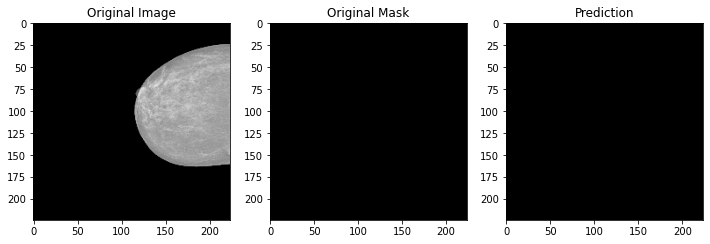

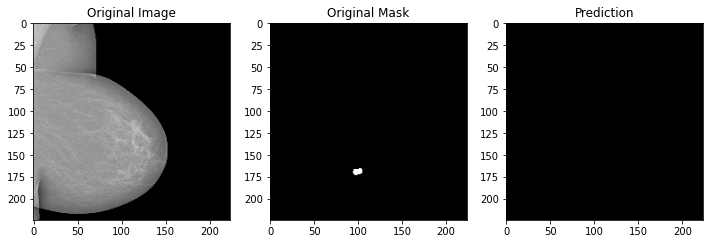

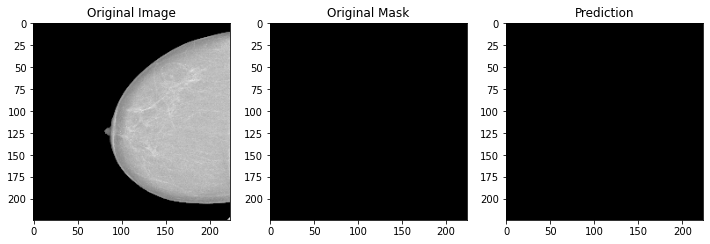

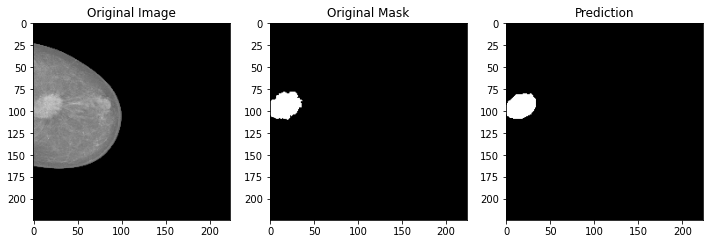

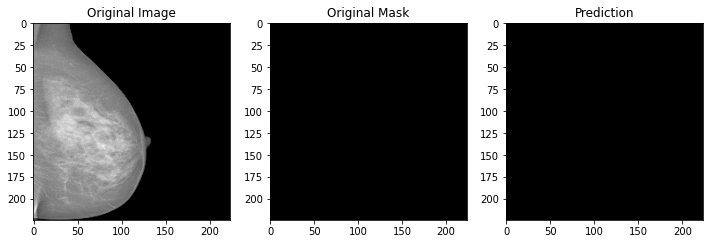

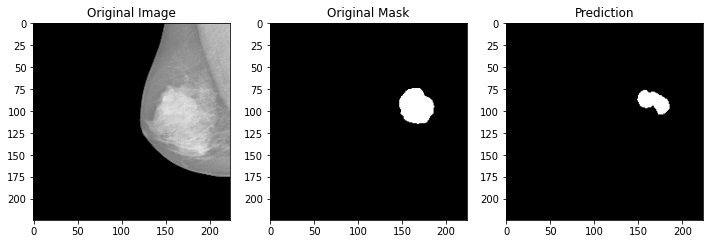

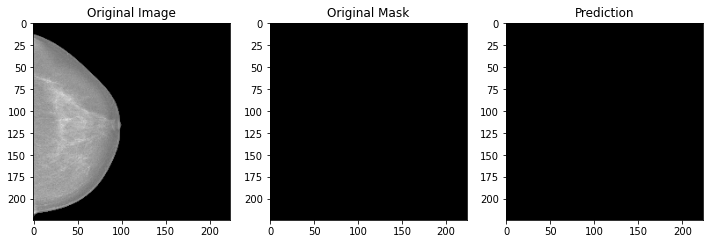

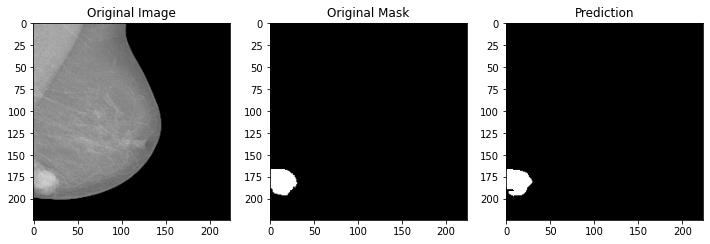

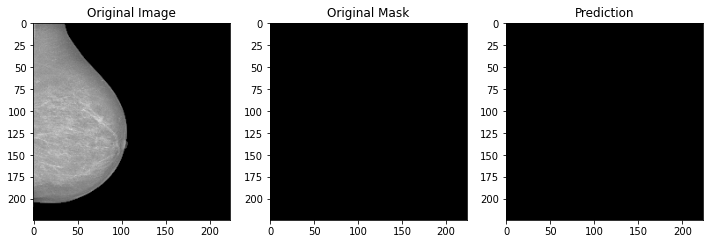

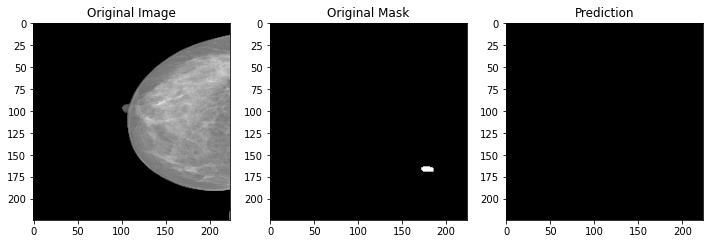

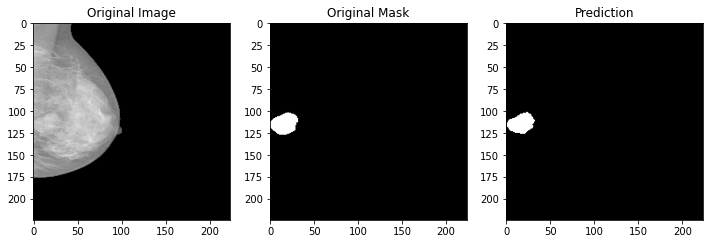

In [ ]:
im_height, im_width = 224,224
for i in range(22):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[i])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    mask = np.squeeze(cv2.imread(df_test['mask'].iloc[i]))
    mask = cv2.resize(mask ,(im_height, im_width))
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5,cmap='gray')
    plt.title('Prediction')
    plt.show()

## Unet with Transfer Leraning without freezing encoder layers

In [ ]:
from segmentation_models import metrics
# define model
model_2 = sm.Unet(encoder_weights='imagenet',encoder_freeze=False)
# model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model_2.compile(optimizer=opt, loss=[sm.losses.bce_dice_loss, sm.losses.bce_jaccard_loss], 
                     metrics=[sm.metrics.precision, sm.metrics.recall, sm.metrics.f1_score, sm.metrics.iou_score])
print(model_2.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_4[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 decoder_stage0_concat (Concate  (None, None, None,   0          ['decoder_stage0_upsampling[0][0]
 nate)                          1024)                            ',                               
                                                                  'block5_conv3[0][0]']           
                                                                                                  
 decoder_stage0a_conv (Conv2D)  (None, None, None,   2359296     ['decoder_stage0_concat[0][0]']  
                                256)                                                              
                                                                                                  
 decoder_stage0a_bn (BatchNorma  (None, None, None,   1024       ['decoder_stage0a_conv[0][0]']   
 lization)                      256)                                                              
          

Found 153 validated image filenames.
Found 153 validated image filenames.
Epoch 1/300
10/10 [==============================] - ETA: 0s - loss: 2.1152 - precision: 0.0049 - recall: 0.6667 - f1-score: 0.0097 - iou_score: 0.0049 Found 39 validated image filenames.
Found 39 validated image filenames.

Epoch 1: val_loss improved from inf to 11.45865, saving model to /content/drive/MyDrive/ModelCheckpoint/Unet with Transfer Leraning without freezing encoder layers__.hdf5
10/10 [==============================] - 164s 16s/step - loss: 2.1152 - precision: 0.0049 - recall: 0.6667 - f1-score: 0.0097 - iou_score: 0.0049 - val_loss: 11.4587 - val_precision: 0.0059 - val_recall: 0.9990 - val_f1-score: 0.0118 - val_iou_score: 0.0059
Epoch 2/300
10/10 [==============================] - ETA: 0s - loss: 1.9545 - precision: 0.0048 - recall: 0.5854 - f1-score: 0.0095 - iou_score: 0.0048
Epoch 2: val_loss improved from 11.45865 to 6.64079, saving model to /content/drive/MyDrive/ModelCheckpoint/Unet with Tr

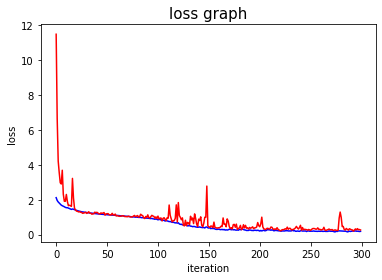

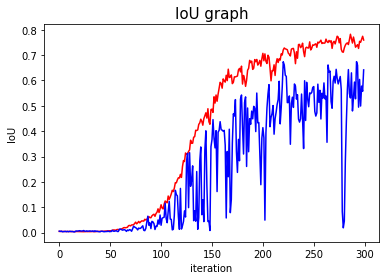

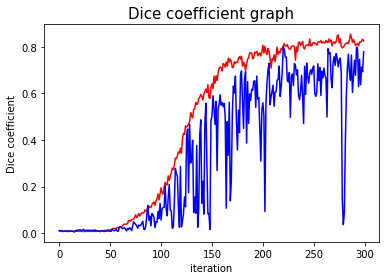

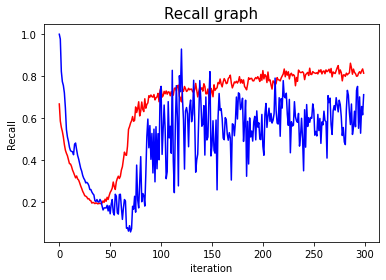

In [ ]:
train_generator_args = dict(rotation_range=0.5,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.05,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
callbacks = [ModelCheckpoint('/content/drive/MyDrive/ModelCheckpoint/Unet with Transfer Leraning without freezing encoder layers__.hdf5', verbose=1, save_best_only=True)]

history = model_2.fit(train_gen,
                    steps_per_epoch=10, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=10)

## plotting curves

a = history.history

plt.figure(1)
plt.plot(a['loss'], 'b-')
plt.plot(a['val_loss'],'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)


plt.figure(2)
plt.plot(a['iou_score'], 'r-')
plt.plot(a['val_iou_score'], 'b-')
plt.xlabel('iteration')
plt.ylabel('IoU')
plt.title('IoU graph', fontsize = 15)


plt.figure(3)
plt.plot(a['f1-score'], 'r-')
plt.plot(a['val_f1-score'], 'b-')
plt.xlabel('iteration')
plt.ylabel('Dice coefficient')
plt.title('Dice coefficient graph', fontsize = 15)

plt.figure(4)
plt.plot(a['recall'], 'r-')
plt.plot(a['val_recall'], 'b-')
plt.xlabel('iteration')
plt.ylabel('Recall')
plt.title('Recall graph', fontsize = 15)

plt.show()

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model_2.evaluate(test_gen, steps=10)

Found 22 validated image filenames.
Found 22 validated image filenames.
10/10 [==============================] - 30s 3s/step - loss: 0.4107 - precision: 0.8892 - recall: 0.4671 - f1-score: 0.6125 - iou_score: 0.4414


In [30]:
print("Test lost:   ",results[0])
print("precision:   ",results[1])
print("Recall   :   ",results[2])
print("f1-score :   ",results[3])
print("iou_score:   ",results[4])

Test lost:    0.4106692969799042
precision:    0.8892439603805542
Recall   :    0.46706947684288025
f1-score :    0.6124524474143982
iou_score:    0.4413920044898987


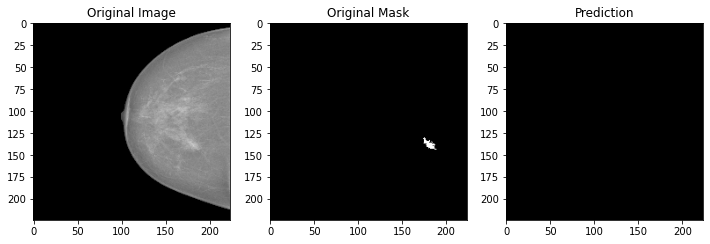

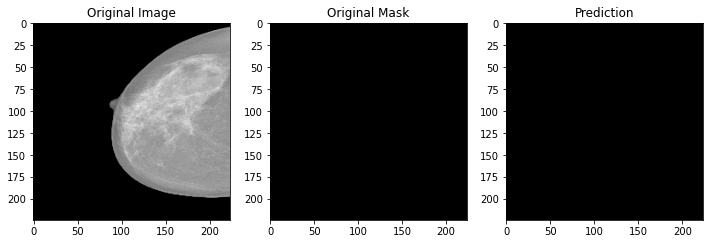

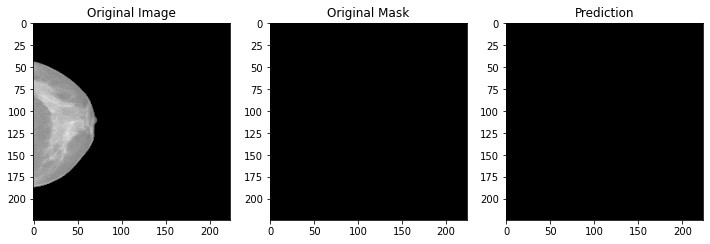

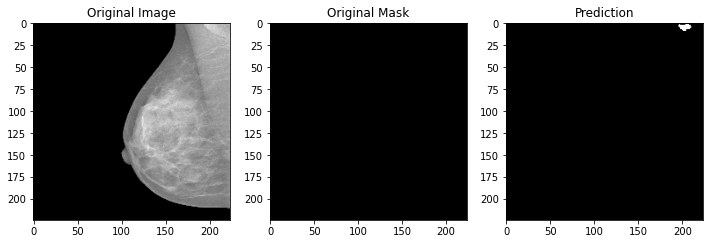

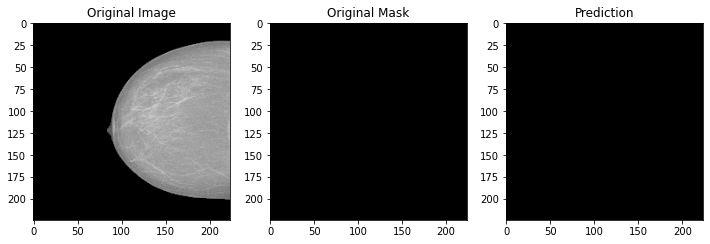

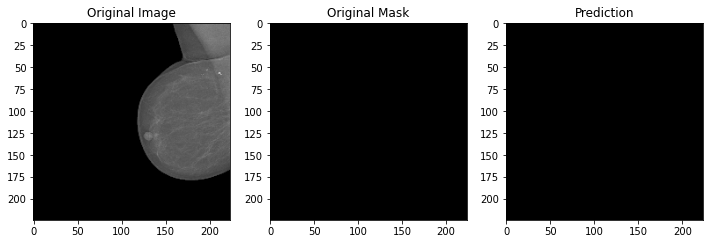

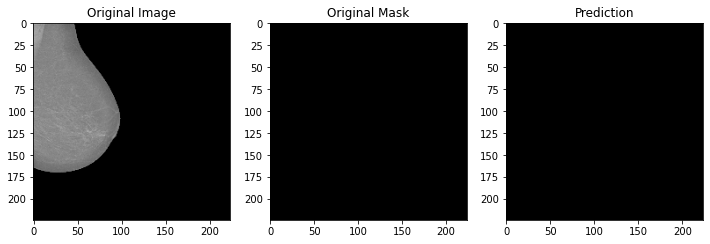

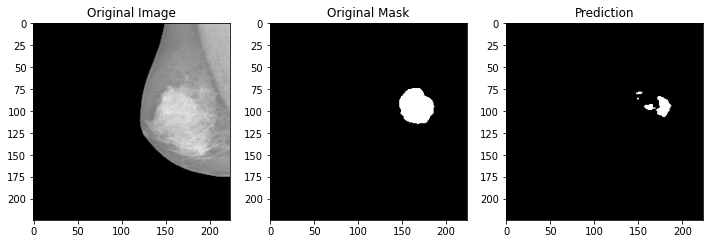

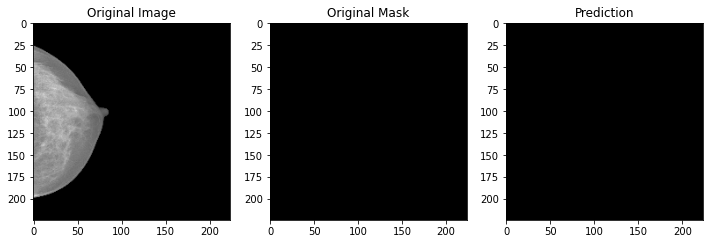

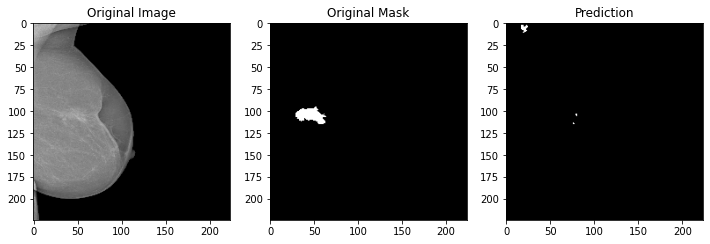

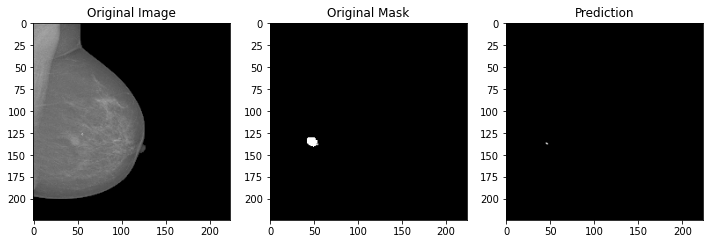

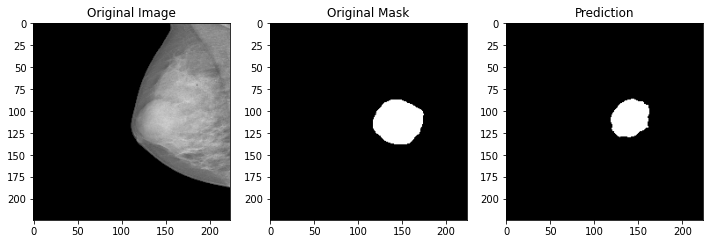

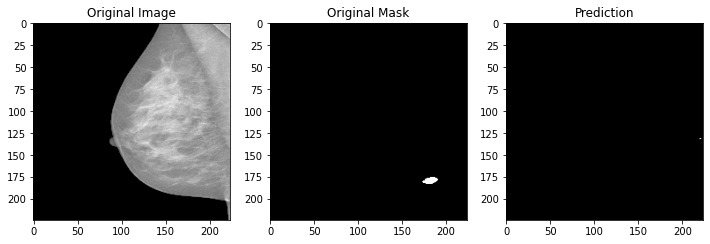

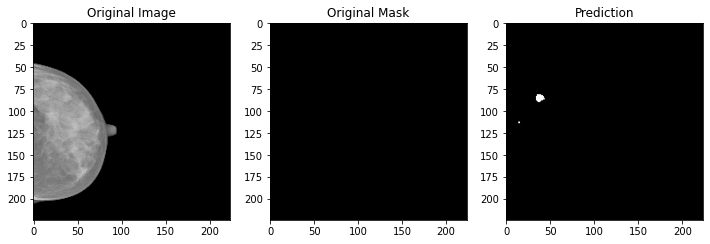

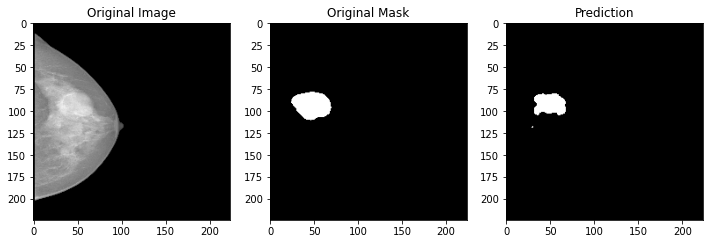

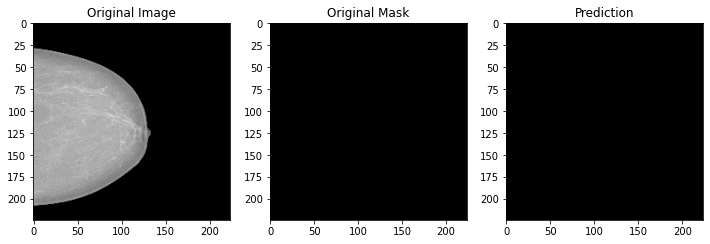

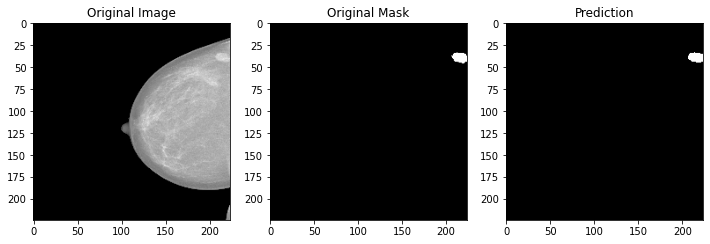

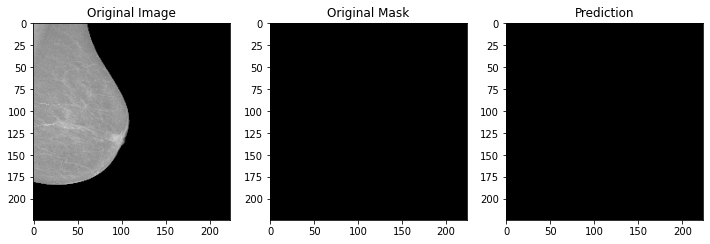

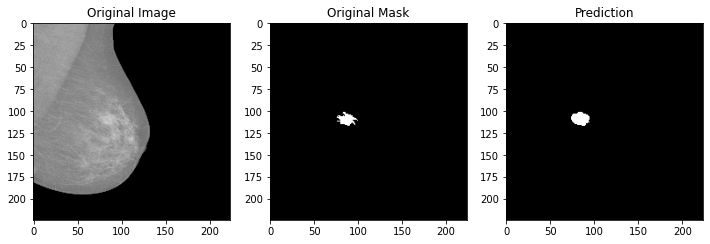

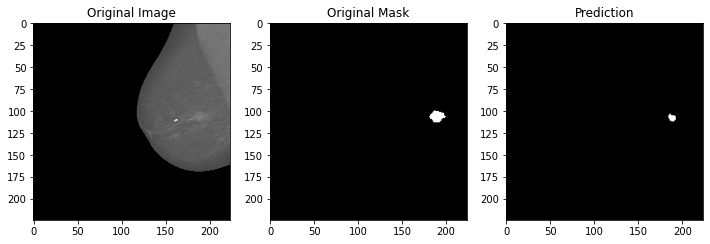

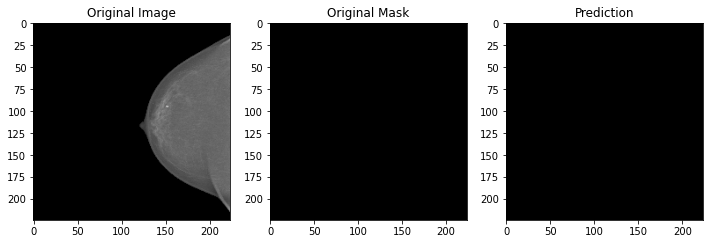

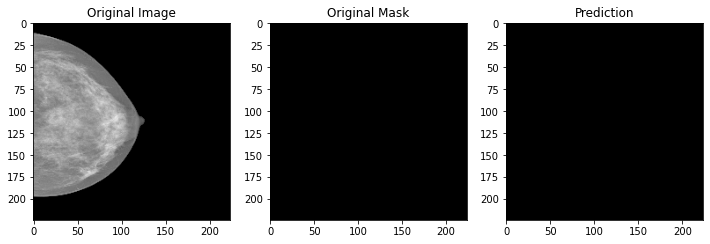

In [ ]:
im_height, im_width = 224,224
for i in range(22):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[i])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model_2.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    mask = np.squeeze(cv2.imread(df_test['mask'].iloc[i]))
    mask = cv2.resize(mask ,(im_height, im_width))
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5,cmap='gray')
    plt.title('Prediction')
    plt.show()

## Unet with TL with freezing encoder layers

In [ ]:
from segmentation_models import metrics
# define model
model_3 = sm.Unet(encoder_weights='imagenet',encoder_freeze=True)
# model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model_3.compile(optimizer=opt, loss=[sm.losses.bce_dice_loss, sm.losses.bce_jaccard_loss], 
                     metrics=[sm.metrics.precision, sm.metrics.recall, sm.metrics.f1_score, sm.metrics.iou_score])
print(model_3.summary())

Found 153 validated image filenames.
Found 153 validated image filenames.
Epoch 1/300
10/10 [==============================] - ETA: 0s - loss: 1.5653 - precision: 0.0042 - recall: 0.4100 - f1-score: 0.0084 - iou_score: 0.0042
Epoch 1: val_loss improved from inf to 1.58845, saving model to /content/drive/MyDrive/ModelCheckpoint/Unet with TL with freezing encoder layers.hdf5
10/10 [==============================] - 88s 10s/step - loss: 1.5653 - precision: 0.0042 - recall: 0.4100 - f1-score: 0.0084 - iou_score: 0.0042 - val_loss: 1.5885 - val_precision: 0.0030 - val_recall: 0.3068 - val_f1-score: 0.0058 - val_iou_score: 0.0029
Epoch 2/300
10/10 [==============================] - ETA: 0s - loss: 1.5337 - precision: 0.0045 - recall: 0.4079 - f1-score: 0.0089 - iou_score: 0.0045
Epoch 2: val_loss improved from 1.58845 to 1.53505, saving model to /content/drive/MyDrive/ModelCheckpoint/Unet with TL with freezing encoder layers.hdf5
10/10 [==============================] - 90s 10s/step - loss: 

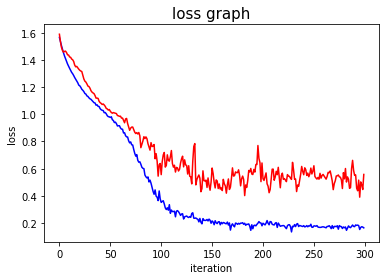

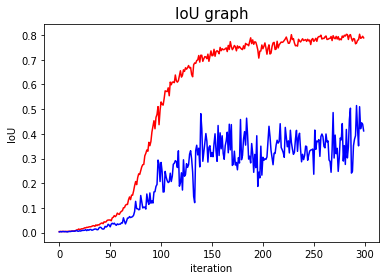

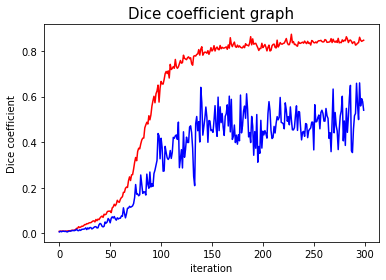

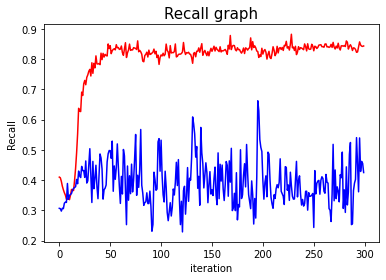

In [31]:
train_generator_args = dict(rotation_range=0.5,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.05,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
callbacks = [ModelCheckpoint('/content/drive/MyDrive/ModelCheckpoint/Unet with TL with freezing encoder layers.hdf5', verbose=1, save_best_only=True)]

history = model_3.fit(train_gen,
                    steps_per_epoch=10, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=10)

## plotting curves

a = history.history

plt.figure(1)
plt.plot(a['loss'], 'b-')
plt.plot(a['val_loss'],'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)


plt.figure(2)
plt.plot(a['iou_score'], 'r-')
plt.plot(a['val_iou_score'], 'b-')
plt.xlabel('iteration')
plt.ylabel('IoU')
plt.title('IoU graph', fontsize = 15)


plt.figure(3)
plt.plot(a['f1-score'], 'r-')
plt.plot(a['val_f1-score'], 'b-')
plt.xlabel('iteration')
plt.ylabel('Dice coefficient')
plt.title('Dice coefficient graph', fontsize = 15)

plt.figure(4)
plt.plot(a['recall'], 'r-')
plt.plot(a['val_recall'], 'b-')
plt.xlabel('iteration')
plt.ylabel('Recall')
plt.title('Recall graph', fontsize = 15)

plt.show()

In [32]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model_3.evaluate(test_gen, steps=10)

Found 22 validated image filenames.
Found 22 validated image filenames.
10/10 [==============================] - 32s 3s/step - loss: 0.4801 - precision: 0.8973 - recall: 0.3954 - f1-score: 0.5489 - iou_score: 0.3782


In [35]:
print("Test lost:   ",results[0])
print("precision:   ",results[1])
print("Recall   :   ",results[2])
print("f1-score :   ",results[3])
print("iou_score:   ",results[4])

Test lost:    0.4801316261291504
precision:    0.8972996473312378
Recall   :    0.3953501582145691
f1-score :    0.548868715763092
iou_score:    0.3782351016998291


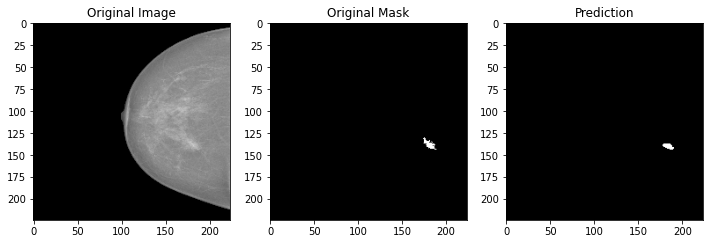

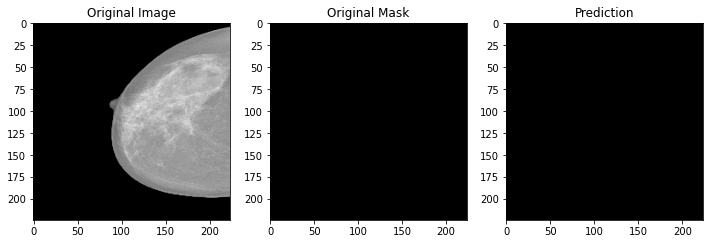

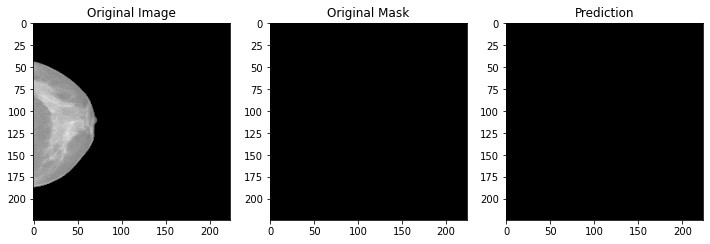

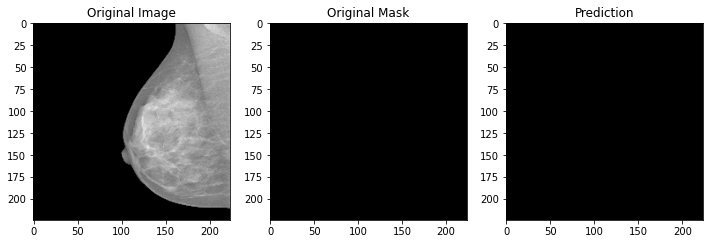

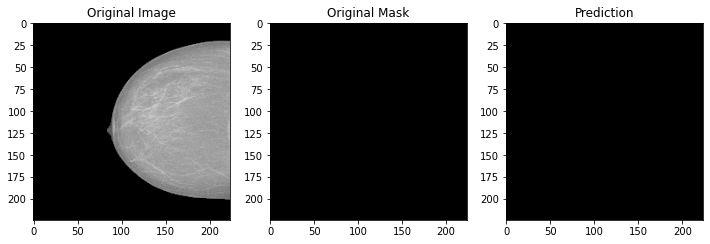

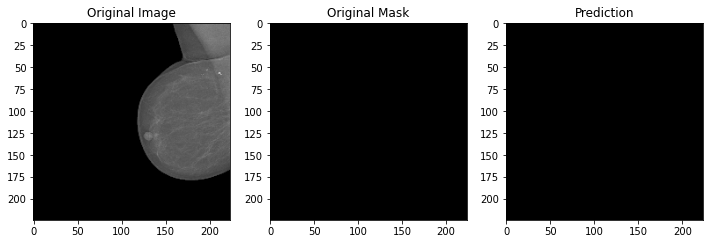

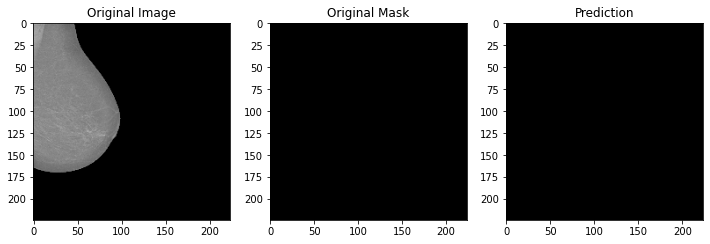

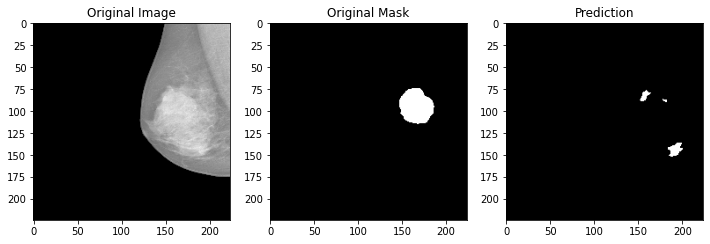

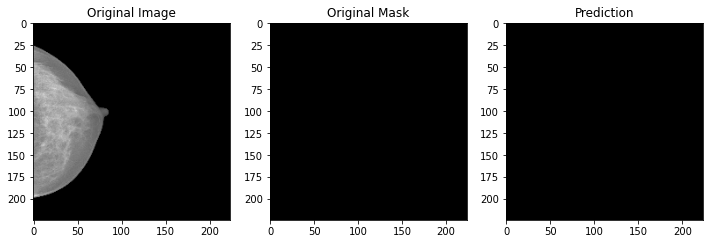

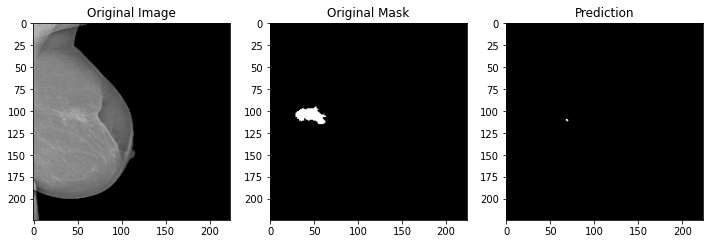

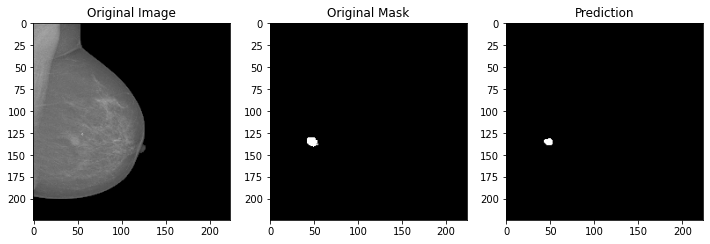

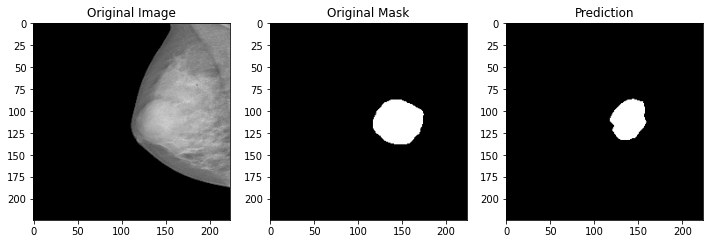

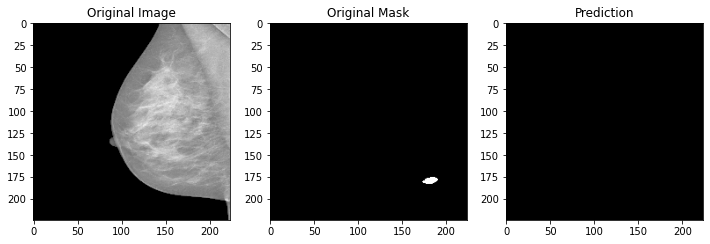

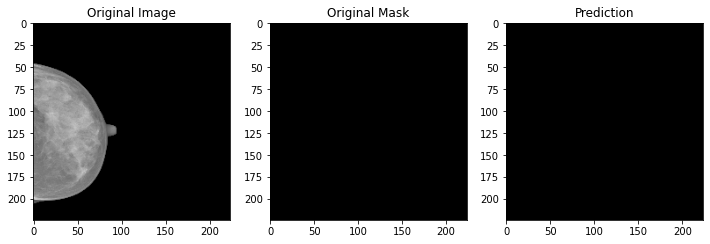

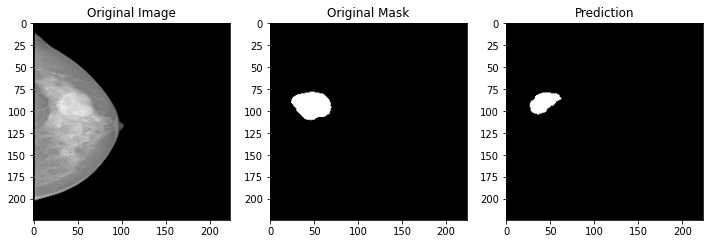

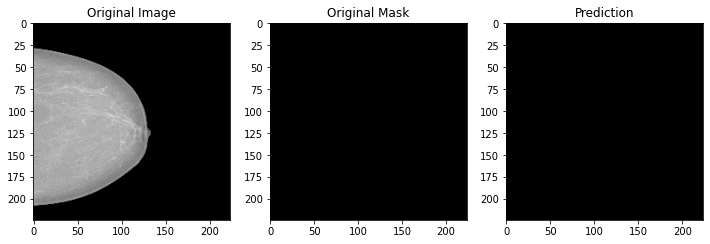

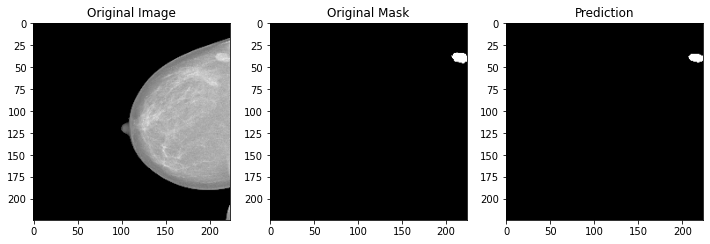

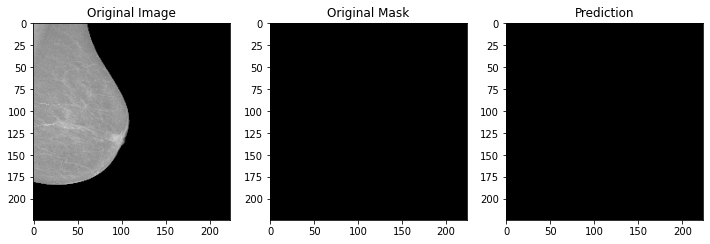

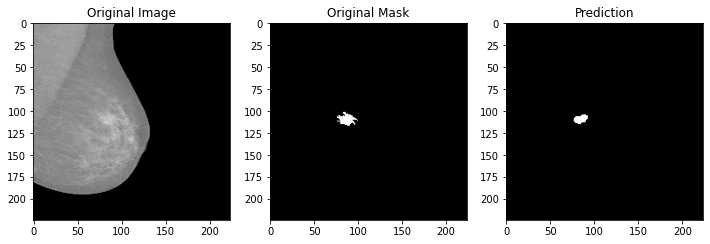

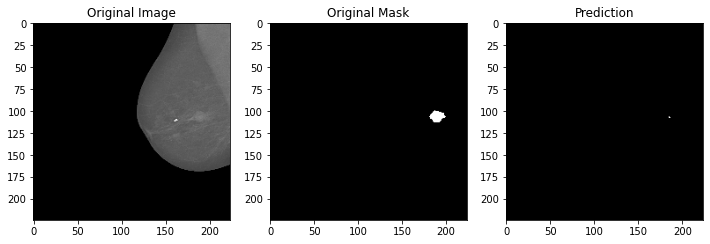

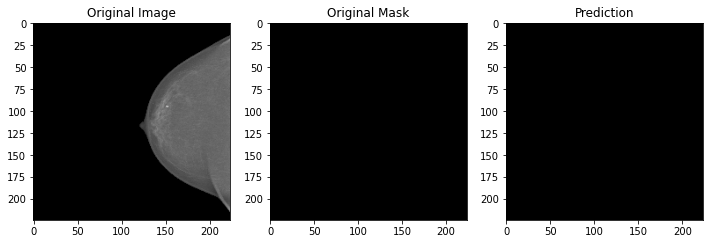

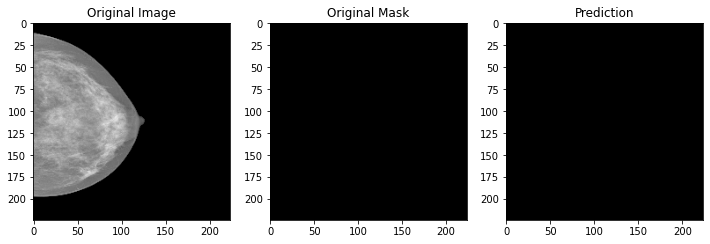

In [34]:
im_height, im_width = 224,224
for i in range(22):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[i])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model_3.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    mask = np.squeeze(cv2.imread(df_test['mask'].iloc[i]))
    mask = cv2.resize(mask ,(im_height, im_width))
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5,cmap='gray')
    plt.title('Prediction')
    plt.show()